In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

# PREPARE DATA

In [ ]:
file2 = open('RNAfold.out', 'r')
lines = file2.readlines()
file2.close()

## CLASS RNA_struct

In [ ]:
class RNA_struct():
    def __init__(self, seq, brackets, mfe, p):
        self.seq = seq
        self.struct = brackets
        self.mfe = mfe
        self.p = p
        self.X, self.graph, self.attr = self.get_graph()
        
    def get_graph(self):
        base_dict = {"A": 0, "U": 1, "G" : 2, "C" : 3}
    
        x = torch.zeros(len(self.seq), 4)
        edges = [[],[]]
        edg_attr = []
    
    
        i = 0
        while i < len(seq):
            
            if self.struct[i] == '(':
                edges[0].append(i)
                edg_attr.append(10)
        
            elif self.struct[i] == ')':
                diff = len(edges[0]) - len(edges[1])
                back = []
            
                j = 0
                while (len(back) < diff) & (i + j < len(self.seq)):
                    diff = len(edges[0]) - len(edges[1])
                                
                    if self.struct[i + j] == ')':
                        back.append(i + j)
                    j += 1           
                
                i += j 
                edges[1] += back[::-1]
       
            i += 1
    
        for i in range(len(self.seq)):
            index = base_dict[seq[i]]
            x[i, index] = 1
            
            if i < len(seq) - 1:
                edges[0].append(i)
                edges[1].append(i + 1)
                edg_attr.append(1)
                
        ins = edges[0] + edges[1]
        outs = edges[1] + edges[0]
        attr = edg_attr + edg_attr
        
        Z = [(y, z) for (x, y, z) in sorted(zip(ins, outs, attr))]
        souts = [i for (i, j) in Z]
        Attr = torch.tensor([j for (i, j) in Z])
        sins = sorted(ins)
        
        E = torch.tensor([sins, souts])
        
        
        return x, E, Attr


## DATASET

In [ ]:
RNA_df = []
mfes = []
n_edges = []
ps = []
for i in range (len(lines)//5):
    #print (i, end=' ')
    seq = lines[5*i][:-1]
    brackets = lines[5*i + 1].split(' ')[0]
    out = lines[5*i + 1].split(' ')[1:]
    if len(out) == 1:
        mfe = float(out[0][1:-2])
    else:
        mfe = float(out[-1][:-2])
    
    mfes.append(mfe)
    p = float(lines[5*i + 4].split(' ')[7][:-1])
    ps.append(p)
    new_rna = RNA_struct(seq, brackets, mfe, p)
    if (p*mfe<0):
        RNA_df.append(new_rna)
    #n_edges.append(len(new_rna.graph[0]))

In [ ]:
len(RNA_df)

9102

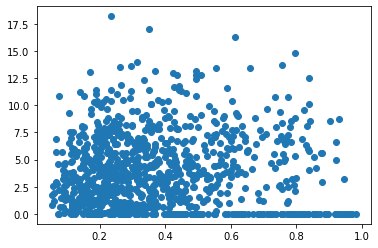

In [ ]:
plt.scatter(ps[:1000], -np.array(mfes[:1000]))

(array([ 130.,  245.,  390.,  534.,  743., 1147., 1471., 2009., 2251.,
        1080.]),
 array([-9.97651  , -9.0143264, -8.0521428, -7.0899592, -6.1277756,
        -5.165592 , -4.2034084, -3.2412248, -2.2790412, -1.3168576,
        -0.354674 ]),
 <BarContainer object of 10 artists>)

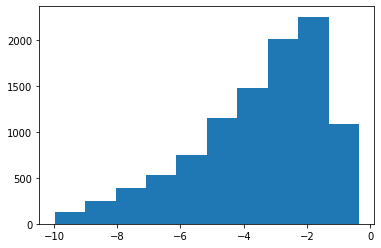

In [ ]:
plt.hist((np.array(mfe)*np.array(ps)))

(array([2.000e+00, 2.000e+00, 1.300e+01, 4.700e+01, 1.560e+02, 4.150e+02,
        9.250e+02, 1.945e+03, 2.942e+03, 3.553e+03]),
 array([-27.9 , -25.11, -22.32, -19.53, -16.74, -13.95, -11.16,  -8.37,
         -5.58,  -2.79,   0.  ]),
 <BarContainer object of 10 artists>)

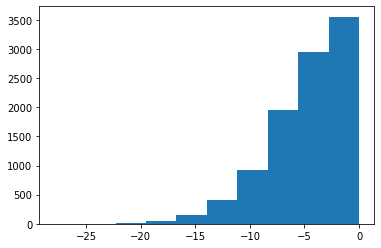

In [ ]:
plt.hist(mfes)

### Torch DATASET

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class RNA_struct_dataset(Dataset):
    
    def __init__ (self, rna_df, threshold=-7):
        self.df = rna_df
        self.threshold = threshold
        self.Data = self.build_Dataset()
        
    def build_Dataset(self):
        
        data = []
        for record in self.df:
            nodes, edges, attr = record.X, record.graph, record.attr
            mfe = record.mfe
            p = record.p
            mfe_masked = int(record.mfe < self.threshold)
            #data.append(Data(x=nodes, edge_index=edges, y=mfe + 7.804015667325573))
            data.append(Data(x=nodes, edge_index=edges, edge_attr=attr, y=mfe*p))
           
        return data
    
    
    def __getitem__(self, index):
        return self.Data[index]
    
    def __len__(self):
        return len(self.Data)

In [ ]:
DATA = RNA_struct_dataset(RNA_df)

In [ ]:
len(train_dataset[0].x)

36

## DATAloader

In [ ]:
from torch_geometric.loader import DataLoader
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# NN architacture

## One Message Passing layer

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Conv2d, Parameter

class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels, emb=False):
        super(GCN, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.emb = emb
        self.bias = Parameter(torch.rand(out_channels))

    def forward(self, x, edge_index):
        
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        if self.emb:
            x = self.lin(x)
            
        row, col = edge_index        
        deg = degree(edge_index[1], x.size(0), dtype=x.dtype)

        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        out = self.propagate(edge_index, x=x, norm=norm)
        out += self.bias

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j  
    
        # here norm.view(-1, 1) has a shape (n_edges, ), as well as x_j 
        # x_j is produced by method __lift__ of original Message Passing Class
        # and basically consists of repetition of esch node representation according to
        # the edges order
        # this is how we can multiply these two matricies

## GNN_ligth

In [ ]:
class GNN_light(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=1, dropout=0.0):
        super(GNN_light, self).__init__()
        
        self.dropout = dropout

        self.convs = pyg_nn.Sequential('x, edge_index', [
            (GCN(input_dim, hidden_dim, emb=True), 'x, edge_index -> x'),
        ])

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, data):
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print(torch.linalg.matrix_norm(x, ord=2))
        x = self.convs(x, edge_index)
        #print(torch.linalg.matrix_norm(x, ord=2))
        x = pyg_nn.global_max_pool(x, batch)
        #print(torch.linalg.matrix_norm(x, ord=2))
        x = self.post_mp(x)
        #print(torch.linalg.matrix_norm(x, ord=2))
        
        return x

## Extended Message

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Conv2d
import torch_geometric.nn as pyg_nn

class EM(torch.nn.Module):
    
    def __init__(self, in_dim, emb_dim, out_dim, batch_size, len_rna, num_layers=5, num_convs=5):
        super(EM, self).__init__()
        
        self.batch_size = batch_size
        self.len_rna = len_rna
        self.dropout = 0.2
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.num_convs = num_convs
        self.Emb = torch.nn.Linear(in_dim, emb_dim)
        self.GCN = GCN (in_dim, emb_dim)
        self.Lin = torch.nn.Linear(emb_dim, emb_dim)
        self.Conv = []
        
        for i in range(self.num_convs):
            self.Conv.append(torch.nn.Conv2d(1, 16, 3, padding = 'same'))
        
        self.Relu = torch.nn.ReLU()
        #self.LSTM = torch.nn.LSTM(self.batch_size*self.len_rna, self.batch_size*self.len_rna, emb_dim)

        
        self.post_mp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(emb_dim, out_dim)
        )
        
    def forward (self, data):
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.Emb(x)
        shape = x.shape
        
        for i in range (self.num_layers):
        
            message = self.GCN(x, edge_index)
            message = self.Lin(message)
            
            for i in range (self.num_convs):
                conv = self.Conv[i](x.view(self.batch_size, 1, self.len_rna, -1))
                conv = torch.mean(conv, dim=1).view(shape)
            
            
            #conv = torch.mean(conv, dim=1).view(shape)
            x = self.Relu(message+conv)
            
            #c = torch.randn(self.batch_size*self.len_rna, self.emb_dim)
            #_, (x, c) = self.LSTM(message, (x, c))
            #print(x.shape)
            x = x.reshape(shape)
        
        x = pyg_nn.global_max_pool(x, batch)
        x = self.post_mp(x)
        
        return x

In [ ]:
from torch_geometric.loader import DataLoader
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
X = batch.x
L = torch.nn.Linear(4, 32)
X = L(X)
x_shape = X.shape

In [ ]:
XX = X.view(batch_size, 1, len_rna, -1)
print (X.shape)
print (XX.shape)
print (X[:36].shape)
print (XX[0].shape)
print (sum(sum(X[:36] == XX[0])))
print (sum(sum(X[36:72] == XX[1])))

torch.Size([360, 32])
torch.Size([10, 1, 36, 32])
torch.Size([36, 32])
torch.Size([1, 36, 32])
tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36])
tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36])


In [ ]:
C = torch.nn.Conv2d(1, 16, 3, padding = 'same')
XXc = C(XX)
print(XXc.shape)
out = torch.max(XXc, dim=1)[0]
print(out.shape)
O = out.view(x_shape)

print (x_shape)
print (out[0].shape)
print (O[:36].shape)
print (out[0] == O[:36])
print (out[1] == O[36:72])

torch.Size([10, 16, 36, 32])
torch.Size([10, 36, 32])
torch.Size([360, 32])
torch.Size([36, 32])
torch.Size([36, 32])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Conv2d
import torch_geometric.nn as pyg_nn

class EM_CNN_only(torch.nn.Module):
    
    def __init__(self, in_dim, emb_dim, out_dim, batch_size, len_rna, num_layers=5, num_convs=5):
        super(EM_CNN_only, self).__init__()
        
        self.batch_size = batch_size
        self.len_rna = len_rna
        self.dropout = 0.2
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.num_convs = num_convs
        self.Emb = torch.nn.Linear(in_dim, emb_dim)
        self.Lin = torch.nn.Linear(emb_dim, emb_dim)
        self.Conv = []
        
        #for i in range(self.num_convs):
        #    self.Conv.append(torch.nn.Conv2d(1, 16, 3, padding = 'same'))
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding = 'same'),
            nn.Conv2d(16, 10, 3, padding = 'same'), 
            nn.Conv2d(10, 1, 3, padding = 'same'),
        )
        
        self.Relu = torch.nn.ReLU()
        #self.LSTM = torch.nn.LSTM(self.batch_size*self.len_rna, self.batch_size*self.len_rna, emb_dim)

        
        self.post_mp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(emb_dim, out_dim)
        )

    '''     
    def train(self, mode=True):
        """
        Override the default train() to freeze the BN parameters
        """
        super(EM_CNN_only, self).train(mode)

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
                m.weight.requires_grad = False
                m.bias.requires_grad = False
    '''

    def forward (self, data):
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.Emb(x)
        shape = x.shape
        
        for i in range (self.num_layers):
        
            #message = self.GCN(x, edge_index)
            #message = self.Lin(message)
            
            
            #for i in range (self.num_convs):
            #    conv = self.Conv[i](x.view(self.batch_size, 1, self.len_rna, -1))
                #conv = torch.mean(conv, dim=1).view(shape)
             #   conv = torch.max(conv, dim=1)[0].view(shape)
            
            
            x = self.conv(x.view(self.batch_size, 1, self.len_rna, -1))
            x = self.Relu(x)
            
            #c = torch.randn(self.batch_size*self.len_rna, self.emb_dim)
            #_, (x, c) = self.LSTM(message, (x, c))
            #print(x.shape)
            x = x.reshape(shape)
        
        x = pyg_nn.global_max_pool(x, batch)
        x = self.post_mp(x)
        
        return x

In [ ]:
mod = EM_CNN_only(4, 32, 1, batch_size, len_rna, num_layers=1, num_convs=5)
list(mod.modules())[0]

EM_CNN_only(
  (Emb): Linear(in_features=4, out_features=32, bias=True)
  (Lin): Linear(in_features=32, out_features=32, bias=True)
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (Relu): ReLU()
  (post_mp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
C = torch.nn.Conv2d(1, 10, 3, padding = 'same')
L = torch.nn.Linear(4, 32)
M = torch.nn.MaxPool1d(10)

In [ ]:
x = L(batch.x)
shape = x.shape
x = C(x.view(batch_size, 1, len_rna, -1))
x = torch.mean(x, dim=1).view(shape)

In [ ]:
rnn = nn.LSTM(32, 32, 82)
input = torch.randn(82, 32)
h0 = torch.randn(82, 32)
c0 = torch.randn(82, 32)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape

torch.Size([82, 32])

In [ ]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear, Conv2d
import torch_geometric.nn as pyg_nn

class EM_inv(torch.nn.Module):
    
    def __init__(self, in_dim, emb_dim, out_dim, batch_size, len_rna, num_layers=1, num_convs=5):
        super(EM_inv, self).__init__()
        
        self.batch_size = batch_size
        self.len_rna = len_rna
        self.dropout = 0.2
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.num_convs = num_convs
        self.Emb = torch.nn.Linear(in_dim, emb_dim)
        self.GCN = GCN (in_dim, emb_dim)
        self.Lin = torch.nn.Linear(emb_dim, emb_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding = 'same'),
            nn.Conv2d(16, 10, 3, padding = 'same'), 
            nn.Conv2d(10, 1, 3, padding = 'same'),
        )
        
        self.Relu = torch.nn.ReLU()
 
        self.post_mp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(emb_dim, out_dim)
        )
        
    def forward (self, data):
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.Emb(x)
        shape = x.shape
        
        for i in range (self.num_layers):

            x = self.conv(x.view(self.batch_size, 1, self.len_rna, -1))
            x = x.reshape(shape)
           
            message = self.GCN(x, edge_index)
            message = self.GCN(x, edge_index)
            message = self.GCN(x, edge_index)
            message = self.Lin(message)

            x = self.Relu(message+x)
            x = x.reshape(shape)
        
        x = pyg_nn.global_max_pool(x, batch)
        x = self.post_mp(x)
        
        return x

# TRAIN

## Metrics

In [5]:
def MSE(input, target):     
    mse_loss = torch.nn.MSELoss()
    return mse_loss(input, target)

def MAE (input, target):
    mae = torch.nn.L1Loss()
    return mae(input, target)

def cross_entropy_loss(x, labels):
    return F.cross_entropy(x, labels)

In [6]:
from tqdm.notebook import trange

from tqdm.notebook import trange
def train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy):

    #train_out = open ('/content/drive/MyDrive/train_out.txt', 'w+')
    #val_out = open ('/content/drive/MyDrive/val_out.txt', 'w+')

    for epoch in trange(epochs):
        batch_train_loss = []
        batch_train_acc = []
        batch_val_accuracy = []

        model.train()
        for batch in train_loader:
            pred = model(batch)
            target = batch.y

            #loss = cross_entropy_loss(pred, target)
            loss = MAE(pred, target)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_train_loss.append(float(loss.data.numpy()))
            #batch_train_acc.append(sum(torch.argmax(pred, dim=1) == target)/len(target))

        train_loss.append(np.mean(batch_train_loss))
        #train_acc.append(np.mean(batch_train_acc))
        #train_out.write(str(train_loss[-1]) + " ")

        model.eval()   ### доделать туть!!!
        for batch in val_loader:
            pred = model(batch)
            #pred = F.softmax(model(batch), dim=1)
            target = batch.y

            #batch_val_accuracy.append(sum(torch.argmax(pred, dim=1) == target)/len(target)) 
            batch_val_accuracy.append(MAE(pred, target))
        
        val_accuracy.append(torch.mean(torch.tensor(batch_val_accuracy)))
        #val_out.write(str(val_accuracy[-1]) + " ")
        
        if epoch%10 == 0:
            print('Epoch = {:>5s},  Train MAE = {:.5f}, Val MAE = {:.5f}'.format(
                 #'Epoch = {:>5s},  Loss = {:.5f}, Train_acc = {:.2%}, Accuracy = {:.2%}'.format(
                    #str(epoch), train_loss[-1].item(), train_acc[-1].item(), val_accuracy[-1].item()) )
                    str(epoch), train_loss[-1].item(), val_accuracy[-1].item()) )
            
    return model   #, train_loss, train_acc, val_accuracy


def plot_progress(train_loss, val_accuracy):

    fig, (train_ax, val_ax) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    train_ax.plot(train_loss)
    train_ax.set_title('Train loss')
    train_ax.set_xlabel('Epoch')

    val_ax.plot(val_accuracy)
    val_ax.set_title('Val MAE')
    val_ax.set_xlabel('Epoch')

    plt.show()

## GCN

  0%|          | 0/20 [00:00<?, ?it/s]

/home/ntorg/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ntorg/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ntorg/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch =     0,  Train MSE = 34.05460, Val MSE = 28.92721
Epoch =    10,  Train MSE = 13.70216, Val MSE = 14.21694


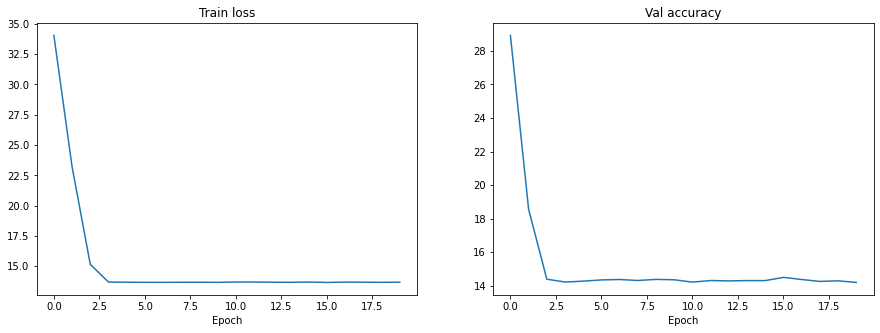

In [ ]:
import torch.optim as optim

hidden_dim = 16
dropout = 0.2
output_dim=1

model = GNN_light(train_dataset[0].x.size(1), hidden_dim, output_dim, dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 31.92909, Val MSE = 27.77067
Epoch =    10,  Train MSE = 13.68535, Val MSE = 14.28514


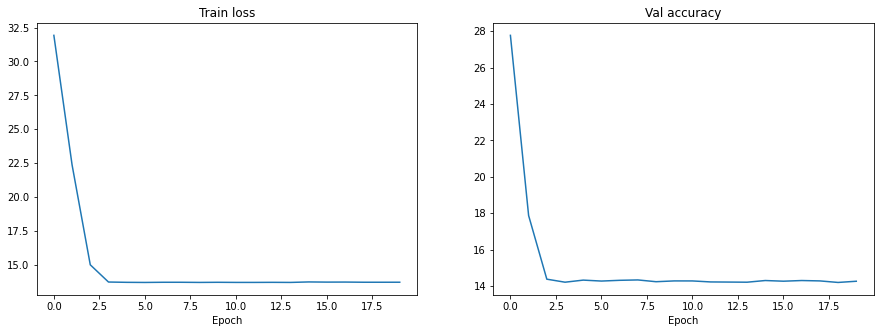

In [ ]:
model = Ext_Message(train_dataset[0].x.size(1), hidden_dim, output_dim, dropout)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

## EM

### before wider conv

In [ ]:
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, 0, 0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#model(batch)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 29.28016, Val MSE = 14.30976
Epoch =    10,  Train MSE = 14.87164, Val MSE = 13.53095


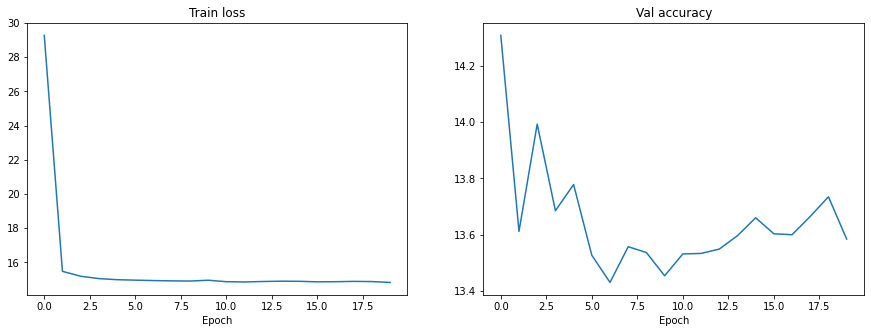

In [ ]:
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 20.01188, Val MSE = 13.74754
Epoch =    10,  Train MSE = 14.60745, Val MSE = 13.53448
Epoch =    20,  Train MSE = 14.14488, Val MSE = 13.64455
Epoch =    30,  Train MSE = 13.98248, Val MSE = 13.54647
Epoch =    40,  Train MSE = 13.92307, Val MSE = 13.56332
Epoch =    50,  Train MSE = 13.91393, Val MSE = 13.51624
Epoch =    60,  Train MSE = 13.90862, Val MSE = 13.59563
Epoch =    70,  Train MSE = 13.91180, Val MSE = 13.44835
Epoch =    80,  Train MSE = 13.92394, Val MSE = 13.44704
Epoch =    90,  Train MSE = 13.90866, Val MSE = 13.58155


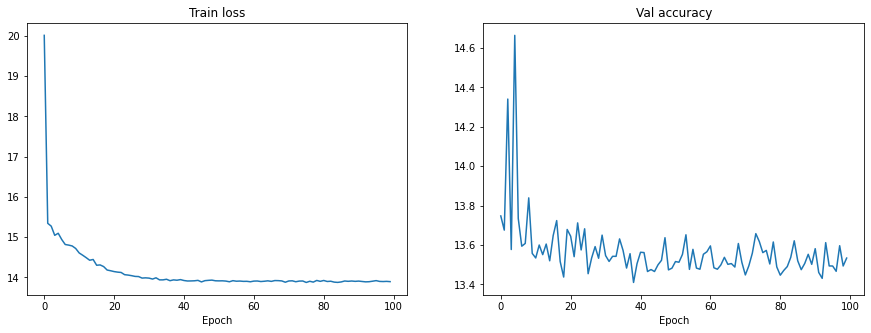

In [ ]:
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna)
optimizer = optim.NAdam(model.parameters(), lr=0.01)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
batch = train_loader.__iter__().next()

In [ ]:
model(batch)[:10]

tensor([[-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887],
        [-4.6887]], grad_fn=<SliceBackward0>)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 3.19901, Val MSE = 2.90280
Epoch =    10,  Train MSE = 2.93589, Val MSE = 2.90206
Epoch =    20,  Train MSE = 2.91879, Val MSE = 2.88747
Epoch =    30,  Train MSE = 2.91140, Val MSE = 2.88142
Epoch =    40,  Train MSE = 2.90568, Val MSE = 2.88141
Epoch =    50,  Train MSE = 2.90221, Val MSE = 2.89867
Epoch =    60,  Train MSE = 2.90538, Val MSE = 2.88577
Epoch =    70,  Train MSE = 2.90489, Val MSE = 2.89704
Epoch =    80,  Train MSE = 2.90222, Val MSE = 2.89527
Epoch =    90,  Train MSE = 2.90221, Val MSE = 2.89296


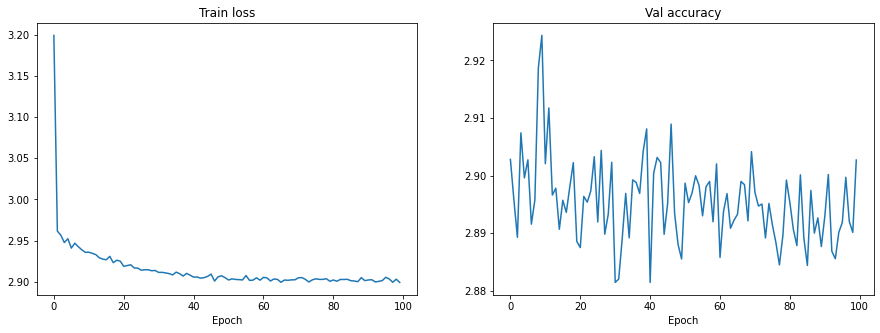

In [ ]:
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna)
optimizer = optim.NAdam(model.parameters(), lr=0.01)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

### wider conv

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 2.88942, Val MSE = 2.45166
Epoch =    10,  Train MSE = 2.15422, Val MSE = 1.97499


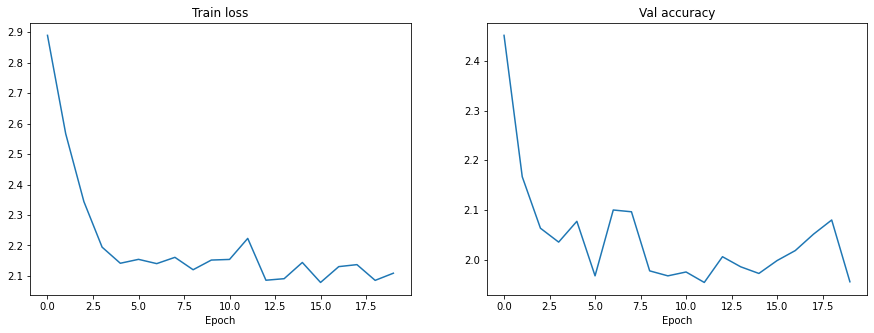

In [ ]:
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 20
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 3.08178, Val MSE = 2.54574
Epoch =    10,  Train MSE = 2.19419, Val MSE = 2.23468
Epoch =    20,  Train MSE = 2.09481, Val MSE = 2.26559
Epoch =    30,  Train MSE = 2.03853, Val MSE = 2.24499
Epoch =    40,  Train MSE = 2.07279, Val MSE = 2.13732
Epoch =    50,  Train MSE = 2.04417, Val MSE = 2.16476
Epoch =    60,  Train MSE = 2.02873, Val MSE = 2.08221
Epoch =    70,  Train MSE = 2.00363, Val MSE = 2.08182
Epoch =    80,  Train MSE = 2.02966, Val MSE = 2.05244
Epoch =    90,  Train MSE = 1.95124, Val MSE = 2.12904


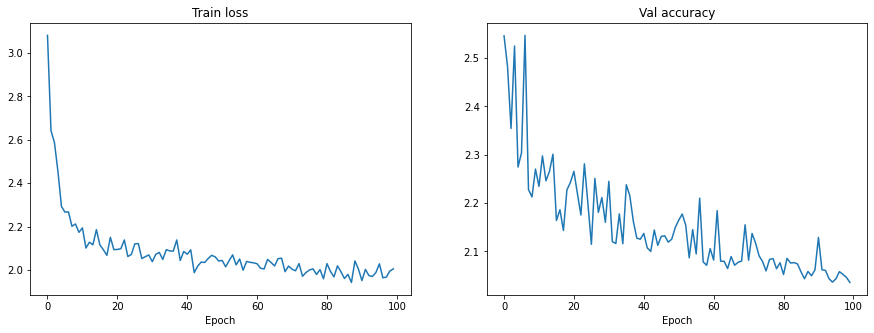

In [ ]:
batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch.y.shape[0], len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

### here batch.size = 1  (!!!!!!)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = train_loader.__iter__().next()
model(batch)

tensor([[-2.2738]], grad_fn=<AddmmBackward0>)

In [ ]:
batch.y

tensor([-2.6000])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 2.80860, Val MSE = 2.92920
Epoch =    10,  Train MSE = 2.24163, Val MSE = 2.11640
Epoch =    20,  Train MSE = 2.01436, Val MSE = 2.17194
Epoch =    30,  Train MSE = 2.03701, Val MSE = 2.02746
Epoch =    40,  Train MSE = 2.01295, Val MSE = 2.09540
Epoch =    50,  Train MSE = 1.93795, Val MSE = 2.01232
Epoch =    60,  Train MSE = 1.89739, Val MSE = 2.08712
Epoch =    70,  Train MSE = 1.83380, Val MSE = 1.96941
Epoch =    80,  Train MSE = 1.87783, Val MSE = 1.95489
Epoch =    90,  Train MSE = 1.89647, Val MSE = 1.98008


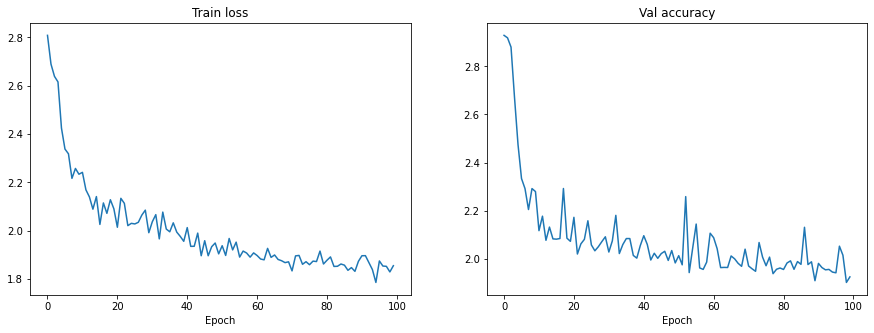

In [ ]:
batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch.y.shape[0], len_rna, num_convs=2, num_layers=3)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

### here batch.size = 1  (!!!!!!)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
batch.y

tensor([-3.8000])

In [ ]:
model(batch)

tensor([[-3.2435]], grad_fn=<AddmmBackward0>)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 2.89342, Val MSE = 2.93177
Epoch =    10,  Train MSE = 2.06464, Val MSE = 2.19314
Epoch =    20,  Train MSE = 2.06862, Val MSE = 2.08272
Epoch =    30,  Train MSE = 2.01202, Val MSE = 2.20431
Epoch =    40,  Train MSE = 1.98287, Val MSE = 2.04569
Epoch =    50,  Train MSE = 1.92245, Val MSE = 2.03099
Epoch =    60,  Train MSE = 1.88400, Val MSE = 2.02279
Epoch =    70,  Train MSE = 1.86834, Val MSE = 2.00152
Epoch =    80,  Train MSE = 1.85422, Val MSE = 1.92659
Epoch =    90,  Train MSE = 1.80198, Val MSE = 1.92564
Epoch =   100,  Train MSE = 1.82317, Val MSE = 1.97025
Epoch =   110,  Train MSE = 1.78825, Val MSE = 1.92449
Epoch =   120,  Train MSE = 1.75604, Val MSE = 1.88370
Epoch =   130,  Train MSE = 1.78181, Val MSE = 1.84455
Epoch =   140,  Train MSE = 1.71795, Val MSE = 1.99014
Epoch =   150,  Train MSE = 1.71645, Val MSE = 1.85336
Epoch =   160,  Train MSE = 1.72754, Val MSE = 1.81201
Epoch =   170,  Train MSE = 1.70902, Val MSE = 1.83408
Epoch =   

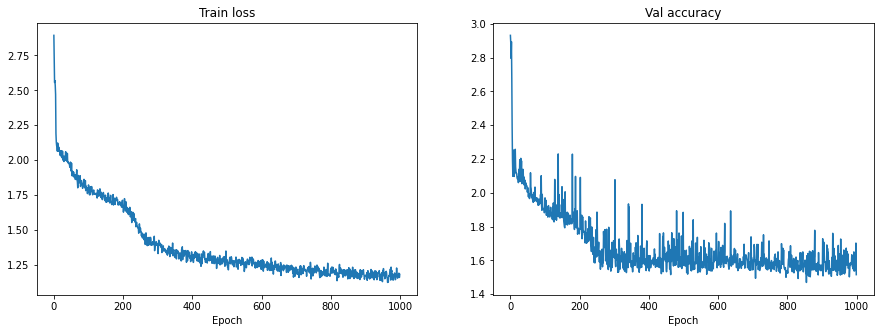

In [ ]:
batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch.y.shape[0], len_rna, num_convs=2, num_layers=3)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

### here batch.size = 1  (!!!!!!)

epochs = 1000
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
model(batch)

tensor([[-0.1871]], grad_fn=<AddmmBackward0>)

In [ ]:
batch.y

tensor([0.])

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = train_loader.__iter__().next()

In [ ]:
model(batch)

tensor([[-0.1549],
        [-3.0056],
        [-1.2520],
        [-0.5539],
        [-0.5793],
        [-2.8872],
        [-2.7239],
        [-2.9626],
        [-1.2994],
        [-7.4411]], grad_fn=<AddmmBackward0>)

In [ ]:
batch.y

tensor([ 0.0000, -3.4000, -1.1000, -4.5000, -0.9000, -3.4000, -2.9000, -4.8000,
        -1.1000, -7.9000])

#### focus

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=100
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
batch = train_loader.__iter__().next()
model(batch)[:10]

tensor([[-2.0342],
        [-4.2991],
        [-7.8703],
        [-6.0792],
        [-6.0416],
        [-0.0261],
        [-7.4509],
        [-5.4542],
        [-4.4725],
        [-0.5207]], grad_fn=<SliceBackward0>)

In [ ]:
batch.y[:10]

tensor([ -0.5000,  -7.9000,  -4.9000,  -1.6000, -11.0000,   0.0000,  -4.4000,
         -2.2000,  -5.1000,  -0.5000])

### batch size = 100

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=100
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 3.80422, Val MSE = 3.52480
Epoch =    10,  Train MSE = 2.94564, Val MSE = 2.68586
Epoch =    20,  Train MSE = 2.75173, Val MSE = 2.62111
Epoch =    30,  Train MSE = 2.73699, Val MSE = 2.61982
Epoch =    40,  Train MSE = 2.74352, Val MSE = 2.62118
Epoch =    50,  Train MSE = 2.74023, Val MSE = 2.62216
Epoch =    60,  Train MSE = 2.73407, Val MSE = 2.62266
Epoch =    70,  Train MSE = 2.74460, Val MSE = 2.62197
Epoch =    80,  Train MSE = 2.73860, Val MSE = 2.62094
Epoch =    90,  Train MSE = 2.73370, Val MSE = 2.62045


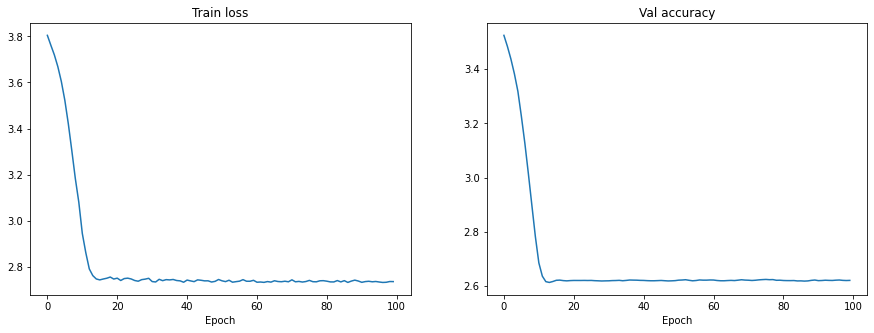

In [ ]:
batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

### decrease relative size of batch

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MSE = 3.11560, Val MSE = 2.94016
Epoch =    10,  Train MSE = 2.92912, Val MSE = 2.92427
Epoch =    20,  Train MSE = 2.91975, Val MSE = 2.92209
Epoch =    30,  Train MSE = 2.90834, Val MSE = 2.92185
Epoch =    40,  Train MSE = 2.89850, Val MSE = 2.93902
Epoch =    50,  Train MSE = 2.89288, Val MSE = 2.92272
Epoch =    60,  Train MSE = 2.89208, Val MSE = 2.92556
Epoch =    70,  Train MSE = 2.88825, Val MSE = 2.92641
Epoch =    80,  Train MSE = 2.88724, Val MSE = 2.92247
Epoch =    90,  Train MSE = 2.88513, Val MSE = 2.92402


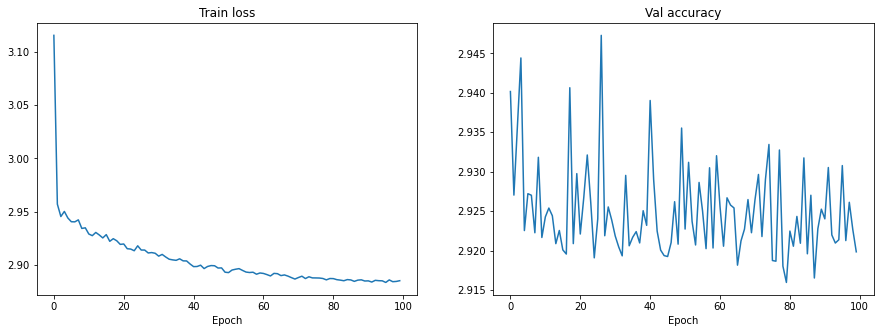

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA, [7000, 2000, 1000])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
batch.y

tensor([-4.2000, -1.5000, -0.8000, -7.6000,  0.0000, -4.4000, -9.4000, -7.1000,
        -6.7000, -3.6000])

In [ ]:
model(batch)

tensor([[-4.1233],
        [-3.8092],
        [-4.0256],
        [-4.0892],
        [-3.8870],
        [-4.3656],
        [-4.0247],
        [-4.1568],
        [-4.2983],
        [-4.0819]], grad_fn=<AddmmBackward0>)

### batch_size = 2

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ntorg/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch =     0,  Train MAE = 3.01056, Val MAE = 2.89233
Epoch =    10,  Train MAE = 2.75537, Val MAE = 2.71841
Epoch =    20,  Train MAE = 2.71860, Val MAE = 2.66917
Epoch =    30,  Train MAE = 2.72067, Val MAE = 2.67918
Epoch =    40,  Train MAE = 2.70115, Val MAE = 2.68145
Epoch =    50,  Train MAE = 2.70545, Val MAE = 2.68271
Epoch =    60,  Train MAE = 2.71286, Val MAE = 2.71436
Epoch =    70,  Train MAE = 2.70854, Val MAE = 2.70943
Epoch =    80,  Train MAE = 2.70751, Val MAE = 2.69413
Epoch =    90,  Train MAE = 2.70607, Val MAE = 2.69432


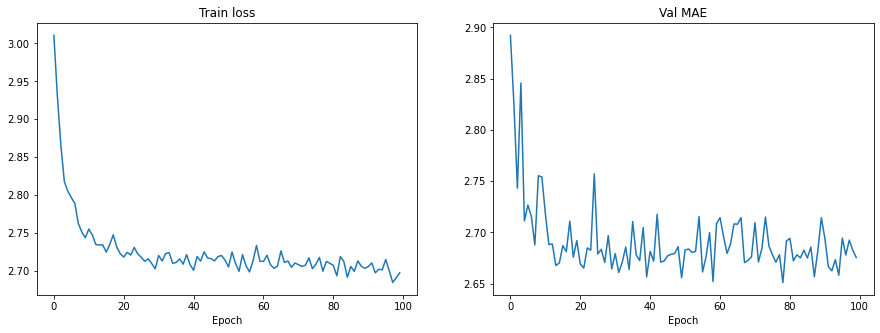

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA, [7000, 2000, 1000])
batch_size=2
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.78454, Val MAE = 2.58297
Epoch =    10,  Train MAE = 2.20834, Val MAE = 2.19974
Epoch =    20,  Train MAE = 2.07944, Val MAE = 2.06058
Epoch =    30,  Train MAE = 1.97294, Val MAE = 2.02826
Epoch =    40,  Train MAE = 1.89436, Val MAE = 1.86057
Epoch =    50,  Train MAE = 1.87092, Val MAE = 2.10990
Epoch =    60,  Train MAE = 1.86281, Val MAE = 1.83762
Epoch =    70,  Train MAE = 1.85604, Val MAE = 1.83304
Epoch =    80,  Train MAE = 1.82278, Val MAE = 1.79435
Epoch =    90,  Train MAE = 1.82868, Val MAE = 1.78453


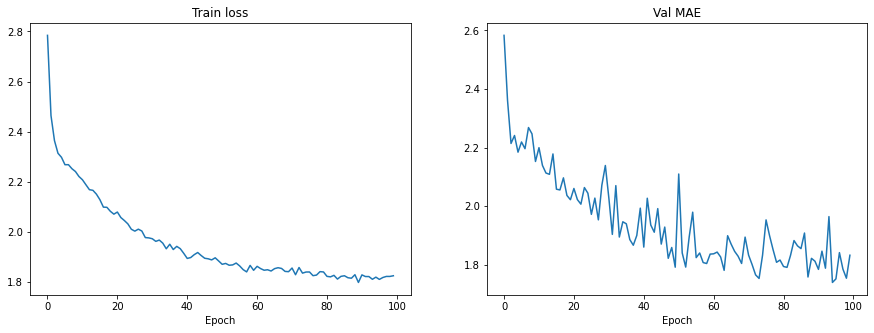

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA, [7000, 2000, 1000])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-4.585053443908691 -4.400000095367432
-2.1182475090026855 -0.8999999761581421
-6.211095333099365 -14.399999618530273
-4.938154220581055 -0.800000011920929
-1.8846843242645264 -2.9000000953674316
-2.237001895904541 -4.5
-3.1202175617218018 -5.199999809265137
-2.834139347076416 -3.799999952316284
-0.8513072729110718 -4.5
-3.2893881797790527 -5.199999809265137


#### super wierd idea: sort dataset

In [ ]:

tmp = []
mfes = []

for i in range (len(lines)//5):
    #print (i, end=' ')
    seq = lines[5*i][:-1]
    brackets = lines[5*i + 1].split(' ')[0]
    out = lines[5*i + 1].split(' ')[1:]
    if len(out) == 1:
        mfe = float(out[0][1:-2])
    else:
        mfe = float(out[-1][:-2])
    mfes.append(mfe)
    new_rna = RNA_struct(seq, brackets, mfe)
    tmp.append(new_rna)
    
#RNA_sorted = [rna for (_, rna) in sorted(zip(mfes, tmp))]

In [ ]:
RNA = [(m, r) for (m, r) in zip(mfes, tmp)]
RNA.sort(key=lambda x:x[0])
RNA_sorted_df = [i[1] for i in RNA]
len(RNA_sorted_df)

10000

In [ ]:
DATA_s = RNA_struct_dataset(RNA_sorted_df)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 3.40909, Val MAE = 2.99978
Epoch =    10,  Train MAE = 2.95212, Val MAE = 2.92454
Epoch =    20,  Train MAE = 2.90330, Val MAE = 2.90880
Epoch =    30,  Train MAE = 2.89493, Val MAE = 2.90541
Epoch =    40,  Train MAE = 2.89323, Val MAE = 2.90530
Epoch =    50,  Train MAE = 2.89323, Val MAE = 2.90572
Epoch =    60,  Train MAE = 2.89293, Val MAE = 2.90585
Epoch =    70,  Train MAE = 2.89224, Val MAE = 2.90547
Epoch =    80,  Train MAE = 2.89236, Val MAE = 2.90604
Epoch =    90,  Train MAE = 2.89224, Val MAE = 2.90566


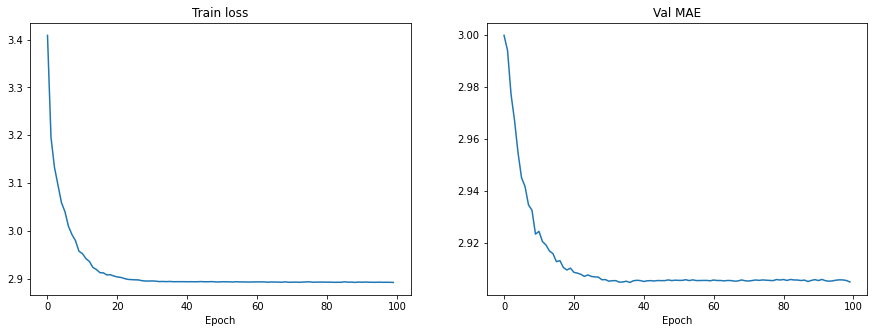

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA_s, [7000, 2000, 1000])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


batch = train_loader.__iter__().next()
model = EM(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
bacch

### turn off message passing

#### batch size 100

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 4.47643, Val MAE = 4.16619
Epoch =    10,  Train MAE = 3.01578, Val MAE = 2.83997
Epoch =    20,  Train MAE = 3.00597, Val MAE = 2.84069
Epoch =    30,  Train MAE = 2.99726, Val MAE = 2.83981
Epoch =    40,  Train MAE = 2.99054, Val MAE = 2.84086
Epoch =    50,  Train MAE = 2.98013, Val MAE = 2.83939
Epoch =    60,  Train MAE = 2.97544, Val MAE = 2.84002
Epoch =    70,  Train MAE = 2.96726, Val MAE = 2.83988
Epoch =    80,  Train MAE = 2.96157, Val MAE = 2.83950
Epoch =    90,  Train MAE = 2.95646, Val MAE = 2.84023


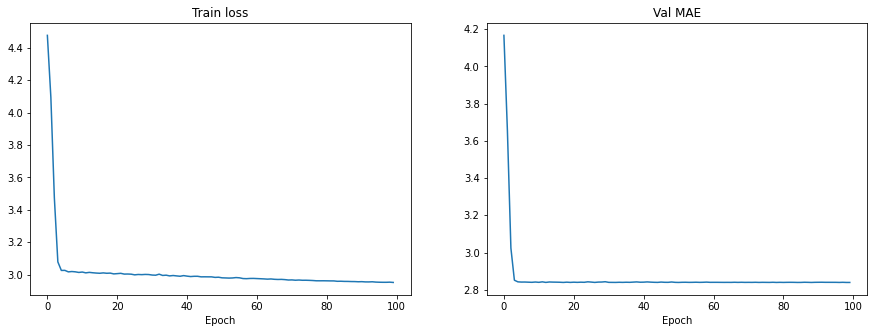

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA, [7000, 2000, 1000])
batch_size=100
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

#### back to bs =1

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.98789, Val MAE = 2.86960
Epoch =    10,  Train MAE = 2.13614, Val MAE = 2.34314
Epoch =    20,  Train MAE = 1.94839, Val MAE = 2.07156
Epoch =    30,  Train MAE = 1.80743, Val MAE = 1.95936
Epoch =    40,  Train MAE = 1.71822, Val MAE = 1.92339
Epoch =    50,  Train MAE = 1.72099, Val MAE = 1.91876
Epoch =    60,  Train MAE = 1.69813, Val MAE = 2.00329
Epoch =    70,  Train MAE = 1.65386, Val MAE = 1.93102
Epoch =    80,  Train MAE = 1.64914, Val MAE = 1.95994
Epoch =    90,  Train MAE = 1.60137, Val MAE = 1.87951


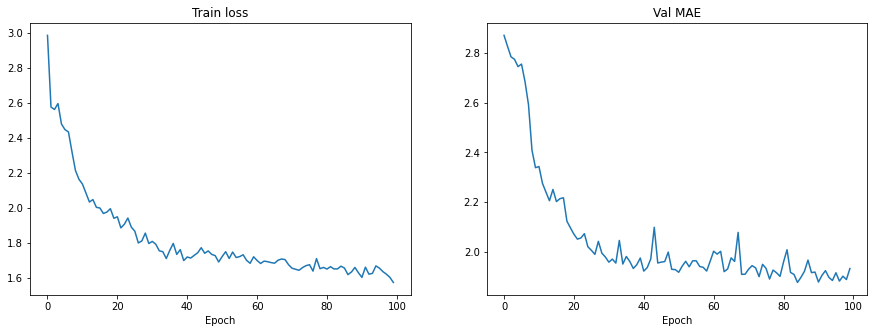

In [ ]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-1.4821131229400635 -0.10000000149011612
-8.330042839050293 -9.0
-1.713047981262207 -4.300000190734863
-5.434557914733887 -7.0
-0.7226783037185669 -0.6000000238418579
-4.579042434692383 -5.699999809265137
-2.9342730045318604 -2.4000000953674316
-6.643517971038818 -8.199999809265137
-3.491036891937256 -18.200000762939453
-0.5063817501068115 -0.6000000238418579


In [ ]:
for i in range(10):
    batch = val_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-2.7833755016326904 -9.600000381469727
-3.5355148315429688 -5.400000095367432
-4.129410266876221 -6.099999904632568
-0.298031210899353 0.0
-1.2047666311264038 -6.5
-0.22038006782531738 -5.5
-0.33383774757385254 -0.6000000238418579
-0.629104495048523 -4.099999904632568
-1.3016910552978516 -1.7999999523162842
-2.835695505142212 -6.5


In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-6.137142181396484 -9.300000190734863
-4.478214263916016 -7.099999904632568
-5.351919174194336 -5.800000190734863
-1.2151931524276733 -1.899999976158142
-2.788910388946533 -3.0999999046325684
-0.7346638441085815 -2.700000047683716
-0.6351419687271118 -5.199999809265137
-3.7559397220611572 -3.299999952316284
-3.382946729660034 -2.0
-1.3376489877700806 -1.7000000476837158


#### increase embedding dimentionality

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.91190, Val MAE = 2.79845
Epoch =    10,  Train MAE = 1.93080, Val MAE = 2.19429
Epoch =    20,  Train MAE = 1.85220, Val MAE = 2.06805
Epoch =    30,  Train MAE = 1.73105, Val MAE = 2.02581
Epoch =    40,  Train MAE = 1.68159, Val MAE = 2.00808
Epoch =    50,  Train MAE = 1.64016, Val MAE = 1.94325
Epoch =    60,  Train MAE = 1.62460, Val MAE = 1.92206
Epoch =    70,  Train MAE = 1.52870, Val MAE = 1.89075
Epoch =    80,  Train MAE = 1.52336, Val MAE = 1.91393
Epoch =    90,  Train MAE = 1.55286, Val MAE = 1.88060


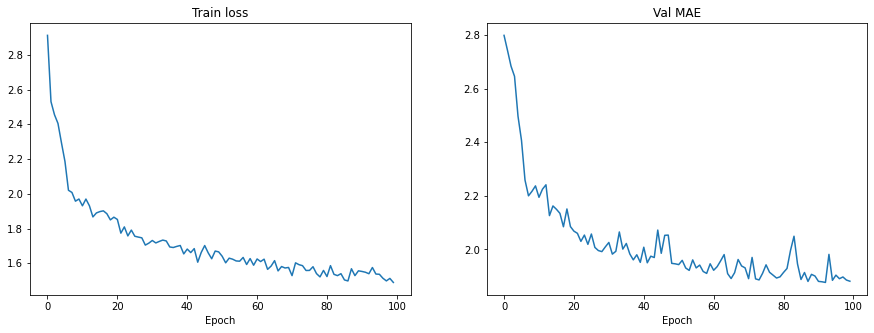

In [ ]:
hidden_dim = 32

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-6.7916765213012695 -9.800000190734863
-3.8225672245025635 -5.199999809265137
-0.14766615629196167 -2.4000000953674316
-3.346118927001953 -1.5
-6.096652507781982 -6.5
-1.2355555295944214 -0.8999999761581421
-3.682939291000366 -5.300000190734863
-4.697973251342773 -3.799999952316284
-4.462224006652832 -2.5999999046325684
-5.037289619445801 -5.900000095367432


#### more

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.83027, Val MAE = 2.49914
Epoch =    10,  Train MAE = 1.86253, Val MAE = 1.87334
Epoch =    20,  Train MAE = 1.73300, Val MAE = 1.83885
Epoch =    30,  Train MAE = 1.68213, Val MAE = 1.71135
Epoch =    40,  Train MAE = 1.59707, Val MAE = 1.69910
Epoch =    50,  Train MAE = 1.57486, Val MAE = 1.68618
Epoch =    60,  Train MAE = 1.55812, Val MAE = 1.73539
Epoch =    70,  Train MAE = 1.48337, Val MAE = 1.71265
Epoch =    80,  Train MAE = 1.46787, Val MAE = 1.83497
Epoch =    90,  Train MAE = 1.44264, Val MAE = 1.65638


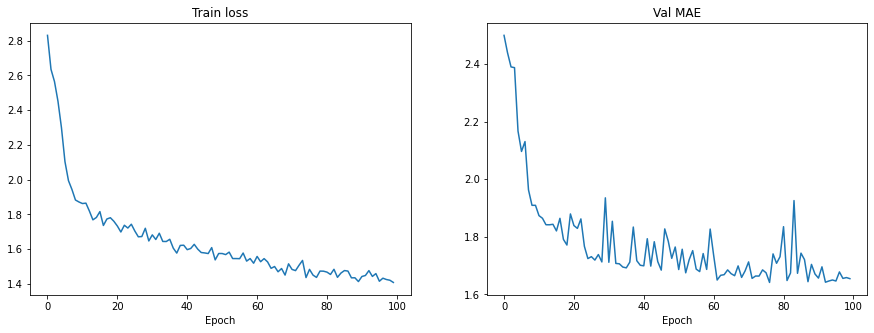

In [ ]:
hidden_dim = 64

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-6.720325946807861 -3.9000000953674316
-0.3130338490009308 -0.20000000298023224
-1.3156423568725586 -2.299999952316284
-4.163390159606934 -5.0
-4.442416667938232 -3.4000000953674316
-5.683712482452393 -6.599999904632568
-7.148843765258789 -4.300000190734863
-0.5932648181915283 -0.8999999761581421
-2.935434103012085 0.0
-2.09609055519104 -0.8999999761581421


#### avg pooling to max pooling

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.63574, Val MAE = 2.61995
Epoch =    10,  Train MAE = 1.89473, Val MAE = 1.83668
Epoch =    20,  Train MAE = 1.77497, Val MAE = 1.72813
Epoch =    30,  Train MAE = 1.69888, Val MAE = 2.06188
Epoch =    40,  Train MAE = 1.71479, Val MAE = 1.72498
Epoch =    50,  Train MAE = 1.66227, Val MAE = 1.72339
Epoch =    60,  Train MAE = 1.65256, Val MAE = 1.66123
Epoch =    70,  Train MAE = 1.64411, Val MAE = 1.61795
Epoch =    80,  Train MAE = 1.55529, Val MAE = 1.67195
Epoch =    90,  Train MAE = 1.58433, Val MAE = 2.00392


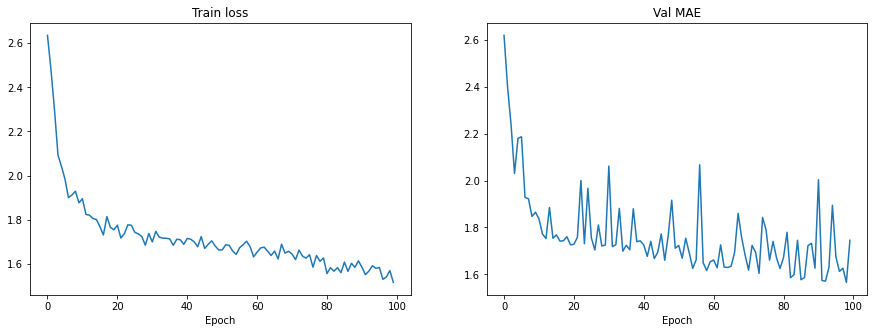

In [ ]:
hidden_dim = 64
# change average pooling of CNN to max pooling

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-1.2531753778457642 -1.2999999523162842
-1.098459005355835 0.0
-6.752528667449951 -4.099999904632568
-4.380155563354492 -6.300000190734863
-4.28925085067749 -9.899999618530273
-0.016178473830223083 0.0
-0.020620979368686676 -0.30000001192092896
-2.207063674926758 -1.899999976158142
-3.18017840385437 -1.7000000476837158
-5.828864097595215 -6.699999809265137


#### form CNN list to nn.Sequential

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.54548, Val MAE = 1.77715
Epoch =    10,  Train MAE = 1.54864, Val MAE = 1.54629
Epoch =    20,  Train MAE = 1.45051, Val MAE = 1.58988
Epoch =    30,  Train MAE = 1.32875, Val MAE = 1.54680
Epoch =    40,  Train MAE = 1.23662, Val MAE = 1.55487
Epoch =    50,  Train MAE = 1.16533, Val MAE = 1.62827
Epoch =    60,  Train MAE = 1.12889, Val MAE = 1.63990
Epoch =    70,  Train MAE = 1.09769, Val MAE = 1.56604
Epoch =    80,  Train MAE = 1.08011, Val MAE = 1.58850
Epoch =    90,  Train MAE = 1.02975, Val MAE = 1.67714


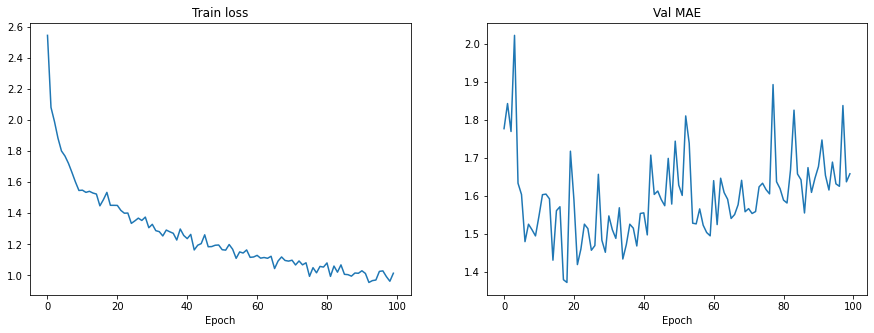

In [ ]:
hidden_dim = 64
# form CNN list to nn.Sequential

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-7.198886871337891 -6.900000095367432
-11.087425231933594 -12.800000190734863
-0.21805667877197266 -0.5
-3.553746223449707 -5.300000190734863
-2.2134435176849365 -2.5
-4.884086608886719 -4.5
-2.157406806945801 -2.299999952316284
-5.199116230010986 -5.400000095367432
-3.1755876541137695 -2.4000000953674316
-2.8777363300323486 -3.5


In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

-2.3520984649658203 -2.0999999046325684
-8.739147186279297 -7.800000190734863
-1.1815141439437866 0.0
0.16028499603271484 0.0
-4.500312805175781 -4.099999904632568
-6.64509391784668 -9.100000381469727
-3.2815616130828857 -6.699999809265137
-9.624753952026367 -8.199999809265137
-0.8366973400115967 -1.899999976158142
-1.028791904449463 -5.900000095367432


#### try bs 10 with new architacure, does not work

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch =     0,  Train MAE = 2.81711, Val MAE = 3.16957
Epoch =    10,  Train MAE = 2.65663, Val MAE = 3.04298
Epoch =    20,  Train MAE = 2.65362, Val MAE = 3.00139
Epoch =    30,  Train MAE = 2.65210, Val MAE = 2.98999
Epoch =    40,  Train MAE = 2.66241, Val MAE = 3.03035
Epoch =    50,  Train MAE = 2.64917, Val MAE = 3.00736
Epoch =    60,  Train MAE = 2.63928, Val MAE = 2.98816
Epoch =    70,  Train MAE = 2.64354, Val MAE = 3.00568
Epoch =    80,  Train MAE = 2.64116, Val MAE = 3.03863
Epoch =    90,  Train MAE = 2.63658, Val MAE = 2.99776


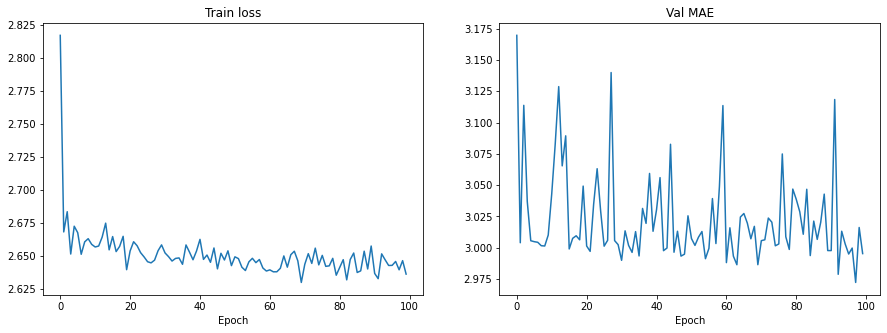

In [ ]:
hidden_dim = 64
# back to batch size 10
# does not work anyway

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_CNN_only(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
print (model(batch), batch.y)

tensor([[-4.0253],
        [-4.1371],
        [-3.0307],
        [-3.8816],
        [-3.5907],
        [-3.5870],
        [-3.6837],
        [-4.5066],
        [-4.1864],
        [-3.9324]], grad_fn=<AddmmBackward0>) tensor([-6.1000, -9.2000,  0.0000, -3.7000, -1.2000,  0.0000, -2.3000, -4.3000,
        -6.9000, -5.8000])


### Message passing after CNN

In [ ]:
hidden_dim = 64
# here not inverted yet

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
print(model(batch), batch.y)

In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=1)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

#### increase number of layers

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

#### more message

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=3, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = train_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

In [ ]:
for i in range(10):
    batch = val_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

#### more message bigger run

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:5000], [3500, 1000, 500])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=3, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 200
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
len(RNA_df)

In [ ]:
mfes = [i.mfe for i in RNA_df]
plt.hist(mfes)

In [ ]:
subset = [[], [], [], [], [], [], [], []]
for rna in RNA_df:
    mfe_id = int(abs(rna.mfe//5))
    #print(mfe_id, rna.mfe)
    if len(subset[mfe_id]) < 2000:
        subset[mfe_id].append(rna)

In [ ]:
test_df = subset[0][:400] + subset[1] + subset[2] + subset[3] + subset[4]
mfe_test = np.array([i.mfe for i in test_df])
plt.hist(mfe_test)

In [ ]:
len(test_df)

In [ ]:
DATA_t = RNA_struct_dataset(test_df)

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA_t[:5000], [3500, 1000, 500])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=3, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

#### now we predict y = mfe*p

##### zadacha - ohuitelno pereobuchitsya na traine

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=3, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 1000
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=10
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=3, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

#### another piece of data

In [2]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[1000:2000], [700, 200, 100])
batch_size=1
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

NameError: ignored

In [ ]:
for i in range(10):
    batch = test_loader.__iter__().next()
    print (model(batch).item(), batch.y.item())

In [ ]:
hidden_dim = 64
# here already inverted

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(DATA[:1000], [700, 200, 100])
batch_size=2
len_rna = len(train_dataset[0].x)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


batch = train_loader.__iter__().next()
model = EM_inv(train_dataset[0].x.size(1), hidden_dim, output_dim, batch_size, len_rna, num_convs=5, num_layers=2)
optimizer = optim.NAdam(model.parameters(), lr=0.001)

epochs = 100
train_loss = []
train_acc = []
val_accuracy = []
model = train(model, optimizer, train_loader, val_loader, epochs, train_loss, train_acc, val_accuracy)
#optimizer = optim.NAdam(model.parameters(), lr=0.001)

plot_progress(train_loss, val_accuracy)

In [ ]:
batch = train_loader.__iter__().next()
print (model(batch), batch.y)

In [ ]:
model(batch)